第三章 分类

一、训练二进制分类器（这个数字是不是5）

二、评价模型
（一）使用交叉验证

（二）混淆矩阵结合精度和召回率

（三）ROC曲线

三、多级分类（这个数字归属1-9中的哪个数字）

四、多标签分类（这个数字是否大于7且属于奇数）

五、多输出分类(对信息和噪声进行分类后，可以对噪声的像素进行赋值，从而达到降噪效果)


In [1]:
import os
os.environ["OMP_NUM_THREADS"]="7"
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784')
mnist

{'data':        pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  pixel8  pixel9  \
 0           0       0       0       0       0       0       0       0       0   
 1           0       0       0       0       0       0       0       0       0   
 2           0       0       0       0       0       0       0       0       0   
 3           0       0       0       0       0       0       0       0       0   
 4           0       0       0       0       0       0       0       0       0   
 ...       ...     ...     ...     ...     ...     ...     ...     ...     ...   
 69995       0       0       0       0       0       0       0       0       0   
 69996       0       0       0       0       0       0       0       0       0   
 69997       0       0       0       0       0       0       0       0       0   
 69998       0       0       0       0       0       0       0       0       0   
 69999       0       0       0       0       0       0       0       0       0   
 
      

In [2]:
X, y = mnist["data"], mnist["target"]
X.shape
y.shape

(70000,)

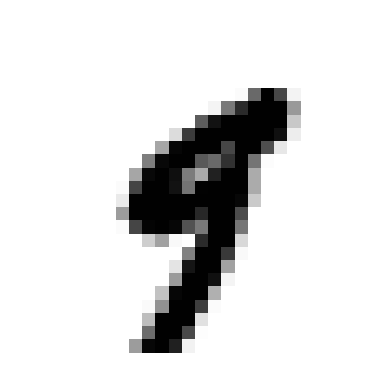

'9'

In [3]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
some_digit = np.array(X)[36000]#随机抽取其中一个例子
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap = matplotlib.cm.binary,interpolation="nearest")#使用imshow函数显示图像。
#cmap参数设置为matplotlib.cm.binary表示使用黑白色彩映射，
#interpolation="nearest"表示使用最近邻插值方法，这可以提高图像的显示速度，但可能会牺牲一些图像质量。
plt.axis("off")#关闭坐标轴的显示
plt.show()
y[36000]

In [4]:
#划分训练集和测试集
X=np.array(X)
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]
np.array(X_test)

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

一、训练二进制分类器

In [5]:
#训练二进制分类器（区分5和非5）
y_train_5=(y_train=="5") # True for all 5s, False for all other digits.给目标带上标签
y_test_5=(y_test=="5")
#使用随机梯度下降分类器（SGDClassifier）：可以高效处理大量数据
from sklearn.linear_model import SGDClassifier
sgd_clf=SGDClassifier(random_state=42)#设置随机种子，使每次运行的结果具有可重复性
sgd_clf.fit(X_train,y_train_5)
#用来预测选中的例子
sgd_clf.predict([some_digit])

array([False])

二、评价模型
（一）使用交叉验证

In [6]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

In [7]:
#等价操作
from sklearn.model_selection import StratifiedKFold#用于创建分层的K折交叉验证分割
from sklearn.base import clone#创建模型的副本
skfolds = StratifiedKFold(n_splits=3)#设置n_splits=3表示将数据集分为3个部分进行交叉验证，random_state=42确保每次运行代码时分割的方式是一致的。
for train_index, test_index in skfolds.split(X_train, y_train_5):
 clone_clf = clone(sgd_clf)
 X_train_folds = X_train[train_index]
 y_train_folds = y_train_5[train_index]
 X_test_fold = X_train[test_index]
 y_test_fold = y_train_5[test_index]
 clone_clf.fit(X_train_folds, y_train_folds)
 y_pred = clone_clf.predict(X_test_fold)
 n_correct = sum(y_pred == y_test_fold)
 print(n_correct / len(y_pred)) 

0.95035
0.96035
0.9604


In [8]:
from sklearn.base import BaseEstimator
class Never5Classifier(BaseEstimator):
 def fit(self, X, y=None):
    pass
 def predict(self, X):
    return np.zeros((len(X), 1), dtype=bool)
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")
#说明对于倾斜数据集，正确率并不是评价分类模型好坏的好方法

array([0.91125, 0.90855, 0.90915])

二、评价模型
（一）使用交叉验证
（二）混淆矩阵


In [9]:
#混淆矩阵
from sklearn.model_selection import cross_val_predict
y_train_pred=cross_val_predict(sgd_clf,X_train,y_train_5,cv=3)
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5,y_train_pred)

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

二、评价模型
（一）使用交叉验证
（二）混淆矩阵结合精度和召回率

In [10]:
#分类器的精度precison=TP/(TP+FP) 准确率
#配合recall使用recall=TP/(TP+FN) 召回率
from sklearn.metrics import precision_score,recall_score
print(precision_score(y_train_5,y_train_pred))
print(recall_score(y_train_5,y_train_pred))
#F1(调和平均值，将更多的权重赋给更小值）
#F1=TP/(TP+(FP+FN)/2)
from sklearn.metrics import f1_score
print(f1_score(y_train_5,y_train_pred))
#F1更喜欢precision和recall的值相差不多的分类模型
#但根据实际应用情景的不同，我们对分类模型的要求不同
#例一：如果选择分类器（实现目的：为孩子筛选好的节目），父母们可能会更喜欢高precison，低recall，“宁缺勿滥”的分类器
#例二：如果选择分类器（实现目的：判断视频监控是否进了扒手），商店老板可能会更喜欢低precision，高recall，“宁愿错杀，斩草除根”的分类器
#你不能两者兼得
#提高分类的阈值，确实可以提高判断的正确性
#但同时也筛选掉了某些真值，使召回率降低

0.8370879772350012
0.6511713705958311
0.7325171197343847


In [11]:
#修改认定的阈值，改变分类结果
y_scores = sgd_clf.decision_function([some_digit])
print(y_scores)
threshold = 0
y_some_digit_pred = (y_scores > threshold)
print(y_some_digit_pred)
threshold = -5000
y_some_digit_pred = (y_scores > threshold)
print(y_some_digit_pred)

[-3491.23647576]
[False]
[ True]


In [12]:
#如何确定合理的阈值
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,method="decision_function")
from sklearn.metrics import precision_recall_curve
precision,recall,thresholds=precision_recall_curve(y_train_5,y_scores)

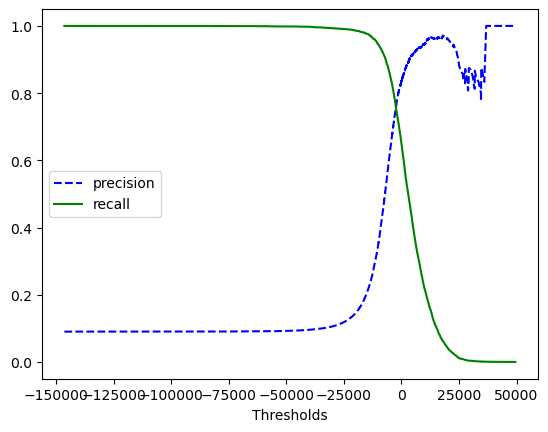

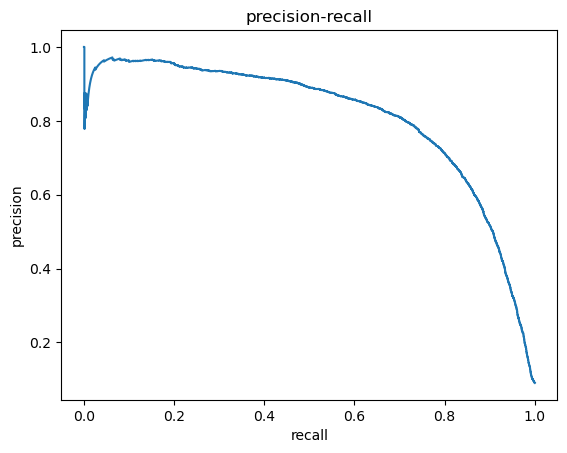

In [13]:
#可视化
import matplotlib
import matplotlib.pyplot as plt
def plot_precision_recall_vs_thresholds(precision,recall,thresholds):
    plt.plot(thresholds,precision[:-1],"b--",label="precision")
    plt.plot(thresholds,recall[:-1],"g-",label="recall")
    plt.xlabel("Thresholds")
    plt.legend(loc="center left")
    plt.show()
plot_precision_recall_vs_thresholds(precision,recall,thresholds)
#precison-thresholds 曲线更崎岖的原因：提高阈值，有时可能会使precison降低
def plot_precision_vs_recall(precision,recall):
    plt.plot(recall,precision)
    plt.title("precision-recall")
    plt.xlabel("recall")
    plt.ylabel("precision")
    plt.show()
plot_precision_vs_recall(precision,recall)

In [14]:
#如果你的目标是达到90%的精确度
#从图中可以看出阈值大概在5000左右
y_train_pred_90=(y_scores>5000)
print(precision_score(y_train_5,y_train_pred_90))
print(recall_score(y_train_5,y_train_pred_90))

0.9160050146259925
0.40435344032466336


二、评价模型
（一）使用交叉验证
（二）混淆矩阵结合精度和召回率
（三）ROC曲线

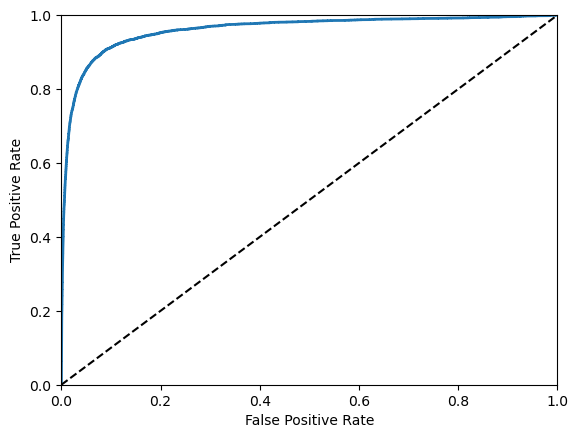

0.9604938554008616


In [15]:
#ROC曲线 TPR_vs_FPR(1-TNR)
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
fpr,tpr,shesholds=roc_curve(y_train_5,y_scores)
def plot_TPR_vs_FDR(fpr,tpr,label=None):
    plt.plot(fpr,tpr,linewidth=2,label=label)
    plt.plot([0,1],[0,1],"k--")
    plt.axis([0,1,0,1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
plot_TPR_vs_FDR(fpr,tpr)
plt.show()
print(roc_auc_score(y_train_5,y_scores))
#选择PR曲线还是ROC曲线：阳性很罕见或者你更关注假阳性而不是假阴性，选择PR曲线
#否则选择ROC曲线




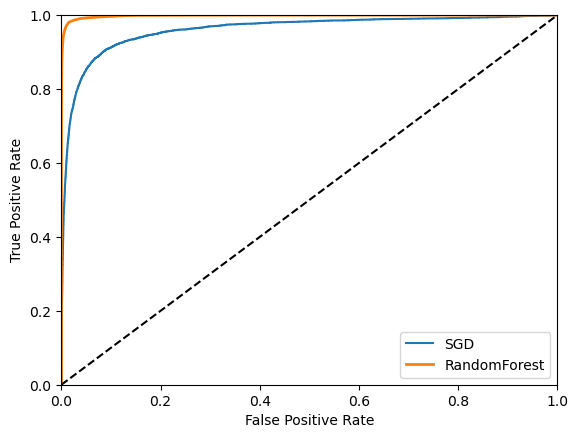

0.9983436731328145

In [16]:
#对比SGDClassifier和RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,method="predict_proba")
#使用属于阳性的概率作为分数
y_score_forest=y_probas_forest[:,1]
fpr_forest,tpr_forest,thresholds_forest=roc_curve(y_train_5,y_score_forest)
plt.plot(fpr,tpr,label="SGD")
plot_TPR_vs_FDR(fpr_forest,tpr_forest,"RandomForest")
plt.legend(loc="lower right")
plt.show()
roc_auc_score(y_train_5,y_score_forest)


三、多级分类

（一）常用算法

1、随机森林分类器（）

2、朴素贝叶斯分类器

（二）常用策略

1、one—versus—all（OvA）[多数算法均默认OVA策略]
2、one-versus-one(OvO)[需要训练N(N-1)/2个二进制分类器，适合与小数据的算法如Support Vector Machine classifiers一起使用（默认OVO策略）：在小数据集上训练多个分类器相对容易]


In [17]:
#在整个训练集上进行训练
sgd_clf.fit(X_train,y_train)
sgd_clf.predict([some_digit])

array(['3'], dtype='<U1')

In [18]:
#获得目标在10个二进制分类器上的得分
some_digit_scores=sgd_clf.decision_function([some_digit])
print(some_digit_scores)
print(np.argmax(some_digit_scores))#找到得分最高的类别
print(sgd_clf.classes_)
print(sgd_clf.classes_[np.argmax(some_digit_scores)])

[[-42309.24702339 -24514.78707295 -21802.99686514   -253.56670849
   -6692.29918582  -5022.40064344 -34623.10033652  -8392.84727568
   -3181.89959952  -2356.71582334]]
3
['0' '1' '2' '3' '4' '5' '6' '7' '8' '9']
3


In [20]:
from sklearn.multiclass import OneVsOneClassifier
ovo_clf=OneVsOneClassifier(SGDClassifier(random_state=42))
ovo_clf.fit(X_train,y_train)
ovo_clf.predict([some_digit])
print(len(ovo_clf.estimators_))

45


In [26]:
forest_clf.fit(X_train,y_train)
print(forest_clf.predict([some_digit]))
forest_clf.predict_proba([some_digit])

['9']


array([[0.  , 0.01, 0.  , 0.01, 0.15, 0.  , 0.  , 0.04, 0.  , 0.79]])

In [28]:
#使用交叉验证验证SGDClassifier预测正确的概率
cross_val_score(sgd_clf,X_train,y_train,cv=3,scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

In [31]:
#对训练集进行缩放提高训练集的预测准确性
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
X_train_scaled=scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf,X_train_scaled,y_train,cv=3,scoring="accuracy")

array([0.8983, 0.891 , 0.9018])

四、误差分析



In [32]:
y_train_pred=cross_val_predict(sgd_clf,X_train_scaled,y_train,cv=3)
conf_mx=confusion_matrix(y_train,y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]],
      dtype=int64)

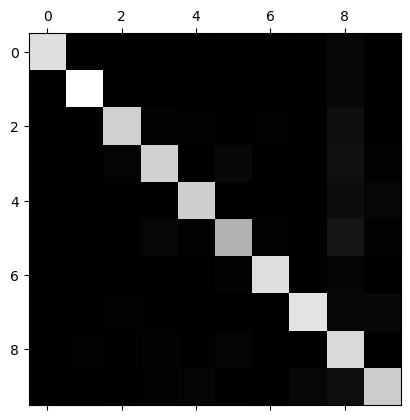

In [33]:
#可视化展示混乱矩阵
plt.matshow(conf_mx,cmap=plt.cm.gray)
plt.show()

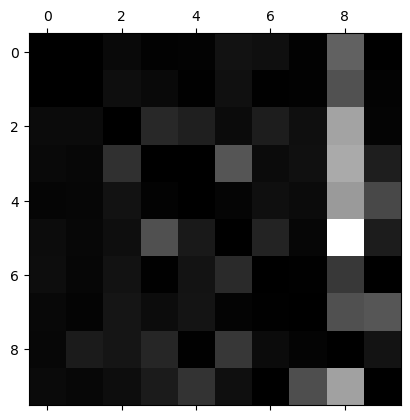

In [34]:
#可视化展示错误
row_sums=conf_mx.sum(axis=1,keepdims=True)
norm_conf_mx=conf_mx/row_sums
np.fill_diagonal(norm_conf_mx,0)#将矩阵的对角元素全部替换为0,以便更好地看出错误
plt.matshow(norm_conf_mx,cmap=plt.cm.gray)
plt.show()
#"8"被误认为其他数字的概率有点高！

In [43]:
def plot_digits(digit_images, images_per_row=5, title=None):
    """
    在一个子图上展示数字图像。
    
    参数:
    - digit_images: 数字图像的数组。
    - images_per_row: 每行展示的图像数量。
    - title: 子图的标题（可选）。
    """
    n_images = len(digit_images)
    n_rows = np.ceil(n_images / images_per_row).astype(int)
    
    # 遍历图像，为每个图像创建一个子图
    for i, image in enumerate(digit_images):
        plt.subplot(n_rows, images_per_row, i + 1)
        plt.imshow(image.reshape((28, 28)), cmap='gray')  # 假设图像是28x28像素
        plt.axis('off')  # 不显示坐标轴
        
        # 如果提供了标题，显示在子图的左上角
        if title is not None:
            plt.title(f'{title} {i + 1}')

    # 调整子图间距，使它们看起来更加整洁
    plt.tight_layout()
    # 显示所有子图
    plt.show()

C:\Users\youyiting\AppData\Local\Temp\ipykernel_20212\2253394691.py:15: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(n_rows, images_per_row, i + 1)


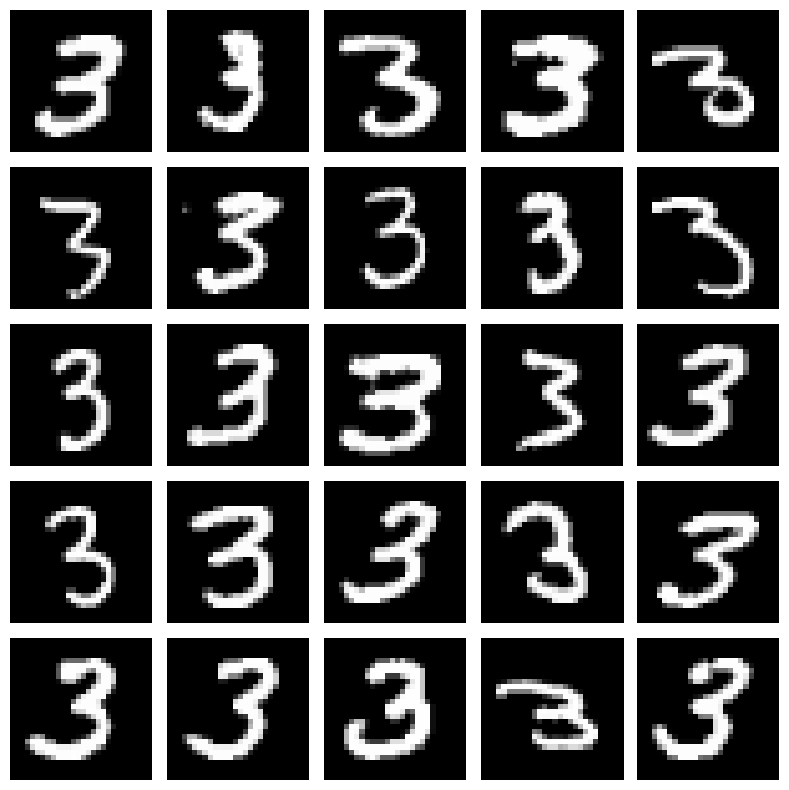

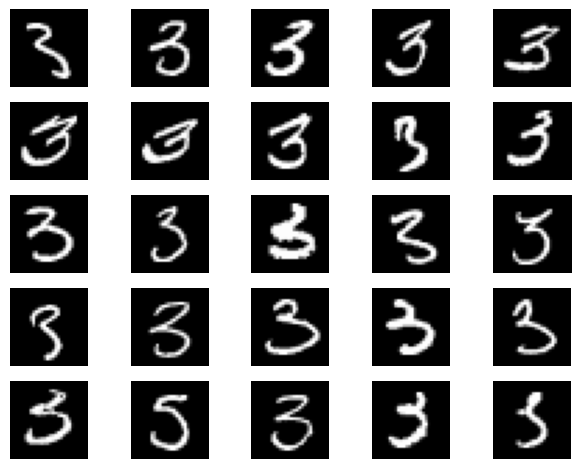

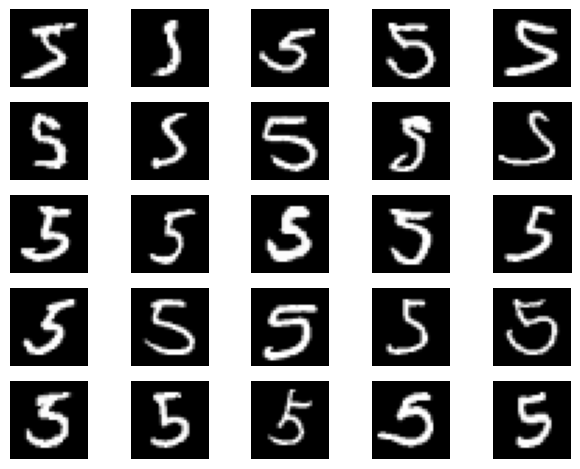

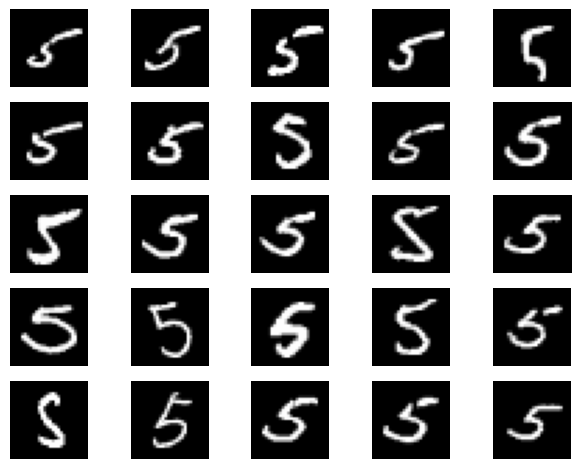

In [44]:
#改善分类模型
X_aa = X_train[(y_train == "3") & (y_train_pred == "3")]
X_ab = X_train[(y_train == "3") & (y_train_pred == "5")]
X_ba = X_train[(y_train == "5") & (y_train_pred == "3")]
X_bb = X_train[(y_train == "5") & (y_train_pred == "5")]
plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()

四、多标签分类

In [54]:
from sklearn.neighbors import KNeighborsClassifier
y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)  
print(y_multilabel)
knn_clf.predict([some_digit])

[[False  True]
 [False False]
 [False False]
 ...
 [False  True]
 [False False]
 [ True False]]


array([[ True,  True]])

In [55]:
#评价多标签模型
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

0.9764102655606048

In [57]:
#评价多标签模型（有权重）
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="weighted")

0.9778357403921755

五、多输出分类

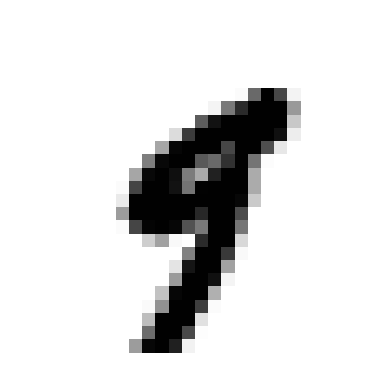

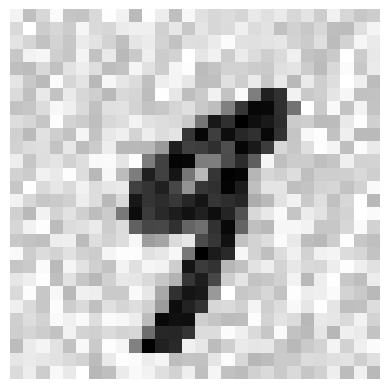

In [74]:
#制造噪声
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

some_digit = np.array(X_train)[36000]#随机抽取其中一个例子
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap = matplotlib.cm.binary,interpolation="nearest")#使用imshow函数显示图像。
plt.axis("off")#关闭坐标轴的显示
plt.show()
some_digit1 = np.array(X_train_mod)[36000]#随机抽取其中一个例子
some_digit_image1 = some_digit1.reshape(28, 28)
plt.imshow(some_digit_image1, cmap = matplotlib.cm.binary,interpolation="nearest")#使用imshow函数显示图像。
plt.axis("off")#关闭坐标轴的显示
plt.show()

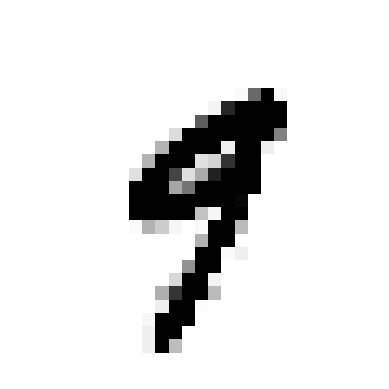

In [73]:
knn_clf.fit(X_train_mod,y_train_mod)
clean_digit=knn_clf.predict(some_digit1.reshape(1,-1))
clean_digit = clean_digit.reshape(28, 28)
plt.imshow(clean_digit, cmap = matplotlib.cm.binary,interpolation="nearest")
plt.axis("off")#关闭坐标轴的显示
plt.show()